# Plotting recombination probability from neutral sex chromosome evolution simulations

The model now outputs recombination probability vectors to directly track the recombination suppression (rather than using the locations of recombination events as a proxy). Here I will make the plotting function for this. 

In [63]:
rv = open("/home/djeffrie/Desktop/Neutral_sex_chrom_evo/Recombination_plotting/Simulations_May_2020/01_sim/rv_files/m_rv_100.out", 'r').readlines()

In [20]:
import numpy as np
from matplotlib import pyplot as plt
import os
import sys
import random
import matplotlib.colors as colors
import matplotlib.cm as cmx


In [88]:
def Iteration_averaged_probs(rv_handle, Gen_jump = 1000):
    
    """
    Get the averaged probability vectors for each base. Calculated by
    averaging the probability vectors across all males. This can take
    a long time so generations can be subsampled using <Gen_jump>.
    
    Returns a dictionary of the averaged probability vector for each generation. 
    
    """

    generations = list(range(0,20000, Gen_jump))

    Per_base_vectors = {}

    print("\t-Generating individual per-base probability vectors")
    
    rv = rv_handle.readlines()
    
    for line in rv:
        if line.startswith("#"):

            gen = int(line.split()[1])
            use_gen = False  ## switch to determine which generations to record.

            if gen in generations:
                Per_base_vectors[gen] = []
                use_gen = True

        ## For each sample, create an array for probabilities at each base
        ## Using numpy arrays makes this much quicker than normal python lists

        else:
            if use_gen == True:
                male_segments = line.split()

                nsegment = 1
                for segment in male_segments:
                    start = int(segment.split("-")[0])
                    end = int(segment.split(":")[0].split("-")[1])
                    prob = float(segment.split(":")[1])
                    scaled_prob = prob/((end+2)-start) ## divide by the number of bases in the segment

                    if nsegment == 1:
                        vector = np.repeat(scaled_prob, ((end+1)-start))
                    else:
                        vector = np.concatenate((vector, np.repeat(scaled_prob, ((end+1)-start))))

                    nsegment += 1

                Per_base_vectors[gen].append(vector)


    print("\t-Averaging over individuals for each generation")
    Per_gen_averages = {}

    for gen in Per_base_vectors:
        Per_gen_averages[gen] = np.mean(np.array(Per_base_vectors[gen]), axis=0 )
        
    return Per_gen_averages

In [89]:
## Get data for all desired iterations

def Get_iteration_data(working_dir, it_range = None, it_list = None, n_its = None, gen_jump = 1000):
    
    """
    working_directory    - The fill path to directory containing the m_rv*.out files.
    it_range             - list or tuple of (start, stop, interval). Uses base python range() function.
    it_list              - a comma separated python list of the iterations to use.
    n_its                - the number of iterations to use in the plot, will be randomly 
                           chosen from available files.     
    gen_jump             - The jump between generations to plot. Default is 1000. Must be a multiple of the 
                           sstat_gen used in the simulation. Must be >= sstat_gen used in the simulation.
    """

    ## Make sure only one of the iteration args is used.
    count = 0
    if it_range:
        count +=1 
        iterations_to_use = list(range(int(it_range[0]), int(it_range[1]), int(it_range[2])))
        
    if it_list:
        count +=1 
        iterations_to_use = it_list
        
    if n_its:
        count +=1 
        available_its = []
        for file_name in os.listdir(working_dir):
            if "m_rv" in file_name:
                available_its.append(file_name.split("_")[2].split(".")[0])
        iterations_to_use = random.sample(available_its, int(n_its))
            
    if count > 1:
        sys.exit("ERROR: More than one iteration specification given")
        
    elif count == 0:
        available_its = []
        for file_name in os.listdir(working_dir):
            if "m_rv" in file_name:
                available_its.append(file_name.split("_")[2].split(".")[0])
        iterations_to_use = available_its
            
    
    print("Plotting data from %s iterations for every %s generations" % (len(iterations_to_use),gen_jump))
    
    Per_iteration_averages = {}
    for file_name in os.listdir(working_dir):
        if "m_rv" in file_name:
            it = file_name.split("_")[2].split(".")[0]
            
            if it in iterations_to_use:
                print("\nProcessing %s" % file_name)
                rv_handle = open("%s/%s" % (working_dir,file_name), "r")
                iteration_avgs = Iteration_averaged_probs(rv_handle, gen_jump)

                Per_iteration_averages[it] = iteration_avgs

    return Per_iteration_averages
        
        

In [90]:
### Now average over the generations across the iterations

def Get_per_gen_average_over_its(Per_it_average_dict):
    
    """
    Converts the averaged proability vectors for each generation
    from all iterations to one vector per generation averaged over
    iterations
    
    """

    Per_gen_vectors = {}
    Per_gen_avgs = {}
    generations = []
    
    ## get vectors by gen
    for it in Per_it_average_dict:
        
        for gen in Per_it_average_dict[it]:
            if not gen in Per_gen_vectors:
                Per_gen_vectors[gen] = []
            if not gen in generations:
                generations.append(gen)
            Per_gen_vectors[gen].append(Per_it_average_dict[it][gen])

    ## Get averages        
    for gen in Per_gen_vectors:
        Per_gen_avgs[gen] = np.mean(np.array(Per_gen_vectors[gen]), axis=0 )
        
    return Per_gen_avgs, generations, len(Per_it_average_dict)


In [91]:
def Plot_rec_probs(Per_gen_avgs, generations, nits):
    
    """
    Plot the averaged probabilities. 
    
    Per_gen_avg - Dictionary of the averaged probabilities per generation across all iterations
    generations - A list of the generations in the simulation output files
    nits        - Number of iterations used to calculate averages in the plot
    
    """
    
    #    plt.style.use('dark_background')
    fig = plt.figure(figsize = (20,10))

    ax1 = plt.subplot()

    ## make some pretty colours

    BuPu = plt.get_cmap("BuPu")
    cNorm  = colors.Normalize(vmin=min(generations)-max(generations)*0.2, vmax=max(generations))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=BuPu)

    colour_index = 0
    plot_max = 0

    ## Plotting 

    for gen in Per_gen_avgs:
        if gen != 0:

            ## track highest value for manually setting the ylim on plots later. 
            if max(Per_gen_avgs[gen]) > plot_max:
                
                plot_max = max(Per_gen_avgs[gen])
            
            colorVal = scalarMap.to_rgba(generations[colour_index])
            ax1.plot(Per_gen_avgs[gen], color=colorVal, label = gen )

            colour_index += 1


    ## Plot formatting ## 

    ax1.set_title("Male recombination probabilities")

    ## remove extra axes
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.patch.set_visible(False)

    ## set the ylim so all plots start from 0
    ax1.set_ylim(0,(plot_max+(plot_max/10)))

    ## add axis labels
    ax1.set_ylabel("Averaged recombination probability per generation (%s iterations)" % nits)
    ax1.set_xlabel("Position (bp)")

    ## inset the axis for the colorbar legend and format it
    cb_inset = fig.add_axes([0.65,0.8,0.2,0.2])
    cb_inset.set_title("Generations")
    cb_inset.imshow((generations,generations), cmap=BuPu, extent=[min(generations),max(generations),0,1000])
    cb_inset.axes.get_yaxis().set_visible(False)
    plt.show()


Plotting data from 12 iterations for every 1000 generations

Processing m_rv_19.out
	-Generating individual per-base probability vectors
	-Averaging over individuals for each generation

Processing m_rv_12.out
	-Generating individual per-base probability vectors
	-Averaging over individuals for each generation

Processing m_rv_10.out
	-Generating individual per-base probability vectors
	-Averaging over individuals for each generation

Processing m_rv_14.out
	-Generating individual per-base probability vectors
	-Averaging over individuals for each generation

Processing m_rv_100.out
	-Generating individual per-base probability vectors
	-Averaging over individuals for each generation

Processing m_rv_1.out
	-Generating individual per-base probability vectors
	-Averaging over individuals for each generation

Processing m_rv_16.out
	-Generating individual per-base probability vectors
	-Averaging over individuals for each generation

Processing m_rv_13.out
	-Generating individual per-base p

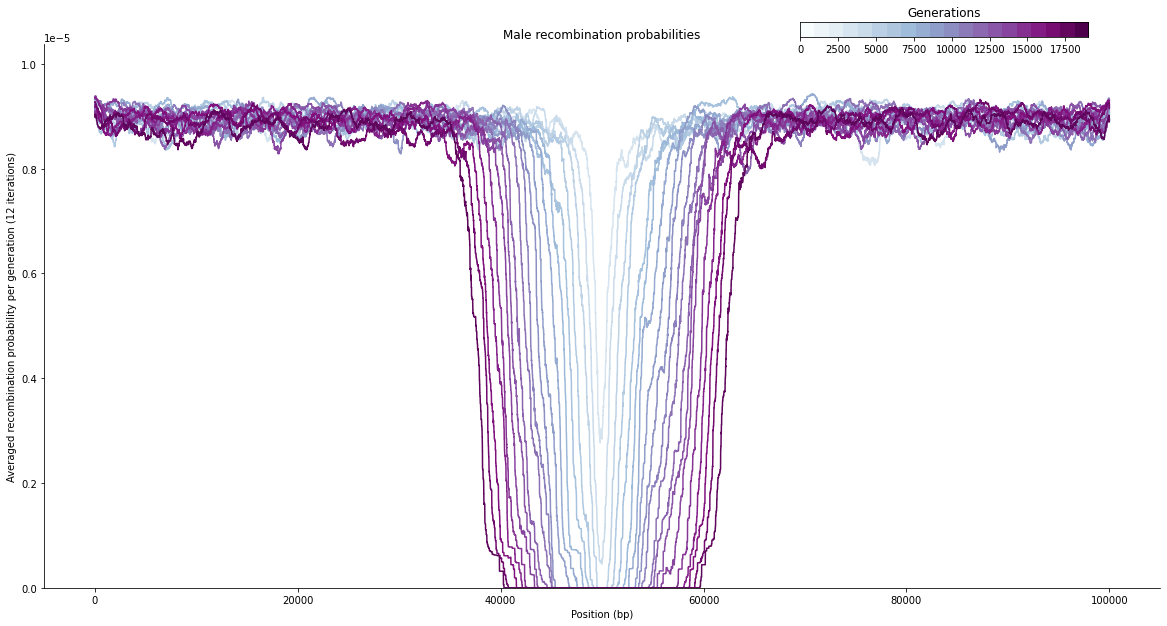

In [92]:
working_dir = "/home/djeffrie/Desktop/Neutral_sex_chrom_evo/Recombination_plotting/Simulations_May_2020/04_sims/rv_files/"

## Get the data for all samples for all gens and for all iterations and average across samples.
Per_it_Avgs  = Get_iteration_data(working_dir)

## Get per generation averages across all iterations
Per_gen_avged_vectors, gens, Nits = Get_per_gen_average_over_its(Per_it_Avgs)

## Plot
Plot_rec_probs(Per_gen_avged_vectors, gens, Nits)